# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

# Fetching and Processing Data

In [2]:
# Load Features
features_filepath = 'data/UCI HAR Dataset/features.txt'
with open(features_filepath) as features_file:
    feature_names = [line.split()[1] for line in features_file.readlines()]

# Load Training Data
train_data_filepath = 'data/UCI HAR Dataset/train/'
X_train_filepath = f'{train_data_filepath}X_train.txt'
y_train_filepath = f'{train_data_filepath}y_train.txt'

X_train = pd.read_csv(X_train_filepath, delim_whitespace=True, header=None)
X_train.columns = feature_names

y_train = pd.read_csv(y_train_filepath, names=['Activity']).iloc[:, 0]

# Load Testing Data
test_data_filepath = 'data/UCI HAR Dataset/test/'
X_test_filepath = f'{test_data_filepath}X_test.txt'
y_test_filepath = f'{test_data_filepath}y_test.txt'

X_test = pd.read_csv(X_test_filepath, delim_whitespace=True, header=None)
X_test.columns = feature_names

y_test = pd.read_csv(y_test_filepath, names=['Activity']).iloc[:, 0]


# Set Up Grid Search And LR Model

In [3]:
# Define hyperparameters grid
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30], 'penalty': ['l2', 'l1']}

# Create a Logistic Regression model
logistic_regression_model = linear_model.LogisticRegression()

# Set up GridSearchCV
log_reg_grid_search = GridSearchCV(logistic_regression_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Train LR Model

In [4]:
# Dictionary to store results
results_dict = {}

# Ignore warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Record the start time for training
training_start_time = datetime.now()
print('Model Training has Started!')

# Fit the logistic regression model
logistic_regression_model.fit(X_train, y_train)

# Print a message indicating the end of training
print('Model Training Done!\n')

# Record the end time for training
training_end_time = datetime.now()

# Calculate and store the training time
results_dict['training_time'] = training_end_time - training_start_time
print('Training Time: {}\n'.format(results_dict['training_time']))

Model Training has Started!
Model Training Done!

Training Time: 0:00:01.878823



# Predicting Test Data

In [5]:
# Print a message indicating the start of the prediction on test data
print('Predicting Test data')

# Record the start time for testing
testing_start_time = datetime.now()

# Predict on the test data
y_pred = logistic_regression_model.predict(X_test)

# Record the end time for testing
testing_end_time = datetime.now()
print('Predictions Done!\n')

# Calculate and store the testing time
results_dict['testing_time'] = testing_end_time - testing_start_time
print('Testing Time: {}\n'.format(results_dict['testing_time']))

# Store the predicted values
results_dict['predicted'] = y_pred

Predicting Test data
Predictions Done!

Testing Time: 0:00:00.019899



# Calculated Accuracy

In [6]:
# Calculate accuracy
accuracy_score = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

# Store accuracy in the results dictionary
results_dict['accuracy'] = accuracy_score

# Print the accuracy
print('Accuracy: {}\n'.format(accuracy_score))

Accuracy: 0.9579233118425518



# Calculating Confusion Matrix

In [7]:
# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Store confusion matrix in the results dictionary
results_dict['confusion_matrix'] = confusion_matrix

# Print the confusion matrix
print('\nConfusion Matrix:')
print('\n{}'.format(confusion_matrix))


Confusion Matrix:

[[492   1   3   0   0   0]
 [ 24 445   2   0   0   0]
 [  4  13 403   0   0   0]
 [  0   3   0 430  58   0]
 [  0   0   0  16 516   0]
 [  0   0   0   0   0 537]]


# Plot Confusion Matrix

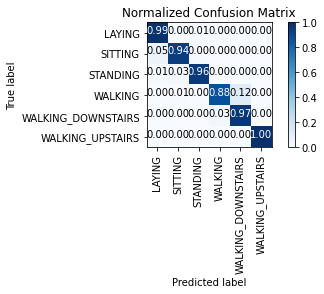

In [8]:
# Set font family
plt.rcParams["font.family"] = 'DejaVu Sans'

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.imshow(normalized_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Define labels and tick marks
labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)

# Format and display values in the cells
fmt = '.2f'
thresh = normalized_cm.max() / 2.
for i, j in itertools.product(range(normalized_cm.shape[0]), range(normalized_cm.shape[1])):
    plt.text(j, i, format(normalized_cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if normalized_cm[i, j] > thresh else "black")

# Set plot layout and labels
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the plot
plt.show()

# Classification Report

In [9]:
# Get classification report
print('Classification Report')
classification_report_result = metrics.classification_report(y_test, y_pred)

# Print the classification report
print(classification_report_result)

Classification Report
              precision    recall  f1-score   support

           1       0.95      0.99      0.97       496
           2       0.96      0.94      0.95       471
           3       0.99      0.96      0.97       420
           4       0.96      0.88      0.92       491
           5       0.90      0.97      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

